In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [4]:
BASE_DIR='/content/drive/MyDrive/IIT_Guwahati/IITG_DigitalSignalProcessorsLab/Music_classification_by_Genre/'
df = pd.read_csv(BASE_DIR+'df_features.csv')
print(df.shape)
df.head()

(1533, 63)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,spectral_contrast_1_mean,spectral_contrast_2_mean,spectral_contrast_3_mean,spectral_contrast_4_mean,spectral_contrast_5_mean,spectral_contrast_6_mean,spectral_contrast_7_mean,spectral_contrast_1_std,spectral_contrast_2_std,spectral_contrast_3_std,spectral_contrast_4_std,spectral_contrast_5_std,spectral_contrast_6_std,spectral_contrast_7_std,mfccs_1_mean,mfccs_2_mean,mfccs_3_mean,mfccs_4_mean,mfccs_5_mean,mfccs_6_mean,mfccs_7_mean,mfccs_8_mean,mfccs_9_mean,mfccs_10_mean,mfccs_11_mean,mfccs_12_mean,mfccs_13_mean,mfccs_14_mean,mfccs_15_mean,mfccs_16_mean,mfccs_17_mean,mfccs_18_mean,mfccs_19_mean,mfccs_20_mean,mfccs_1_std,mfccs_2_std,mfccs_3_std,mfccs_4_std,mfccs_5_std,mfccs_6_std,mfccs_7_std,mfccs_8_std,mfccs_9_std,mfccs_10_std,mfccs_11_std,mfccs_12_std,mfccs_13_std,mfccs_14_std,mfccs_15_std,mfccs_16_std,mfccs_17_std,mfccs_18_std,mfccs_19_std,mfccs_20_std
0,609_Pop_music.wav,0.036,0.057,1.860,3.500,0.175,0.162,0.045,0.034,16.606,13.296,15.925,15.537,16.275,16.261,28.048,6.057,4.467,4.573,3.893,3.808,3.691,7.546,-260.692,43.313,-7.039,9.180,3.865,0.702,-5.252,6.578,0.107,3.057,-0.916,3.250,0.371,5.766,0.208,3.238,0.060,4.172,-1.237,2.582,199.127,54.178,20.653,18.085,15.636,9.473,10.900,8.767,8.044,8.580,8.494,8.454,7.910,7.228,8.833,8.011,7.052,9.464,6.682,6.181
1,610_Rock_music.wav,0.059,0.074,1.041,0.105,0.141,0.035,0.073,0.013,19.715,13.201,17.133,15.885,17.269,16.682,35.089,4.429,3.653,4.409,2.864,3.088,2.978,2.583,-103.569,77.074,-6.254,19.480,-19.928,10.341,-19.461,9.033,-9.488,-5.314,-4.464,-2.109,-11.907,-5.584,-8.315,-2.183,-3.870,-0.628,-7.184,6.063,23.638,12.343,9.581,8.101,9.576,5.473,7.758,5.969,5.651,6.022,7.253,6.138,5.308,5.406,5.391,5.156,5.422,5.978,7.196,7.166
2,611_Rhythm_blues.wav,0.036,0.047,1.538,1.123,0.122,0.031,0.045,0.010,17.738,14.097,16.981,18.711,20.515,20.317,33.097,5.030,3.268,3.691,3.272,3.170,2.663,2.631,-181.099,92.825,-6.661,44.721,-0.932,6.767,4.613,9.766,-3.592,6.806,-0.240,-5.858,-10.314,2.635,-6.559,0.850,-4.857,1.550,-0.056,0.914,31.406,11.137,10.039,11.930,6.597,6.351,11.852,8.131,5.683,8.636,7.588,7.873,7.681,8.094,7.423,6.226,5.502,5.460,6.841,6.302
3,614_Pop_music.wav,0.168,0.218,1.263,0.558,0.111,0.099,0.210,0.058,21.876,16.330,18.420,17.171,17.409,17.156,30.913,4.872,4.724,4.904,4.067,3.178,2.492,2.479,-65.324,82.579,9.975,18.666,8.641,9.930,5.008,6.612,-2.833,-0.958,-1.778,2.432,-4.815,3.302,-3.940,2.342,-1.182,2.545,-3.050,5.490,58.322,32.820,25.745,16.548,14.979,12.627,10.371,11.444,9.041,8.896,7.915,8.169,6.906,8.631,7.943,7.391,7.093,6.566,7.764,7.615
4,616_Techno.wav,0.140,0.178,1.132,0.261,0.196,0.109,0.175,0.030,22.888,13.877,16.916,17.069,17.331,19.074,33.093,4.815,3.326,3.827,2.997,2.328,2.788,2.720,-18.134,66.334,-2.129,13.704,-7.247,-1.933,-11.554,-1.294,-7.839,3.380,-7.956,-4.404,-8.134,-7.968,-13.381,-3.025,-9.868,-6.779,-9.854,1.058,32.883,40.250,19.733,15.595,8.443,7.293,6.096,7.413,5.775,6.199,6.633,5.630,4.981,5.884,6.329,5.614,4.805,7.199,5.439,5.961


In [5]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,spectral_contrast_1_mean,spectral_contrast_2_mean,spectral_contrast_3_mean,spectral_contrast_4_mean,spectral_contrast_5_mean,spectral_contrast_6_mean,spectral_contrast_7_mean,spectral_contrast_1_std,spectral_contrast_2_std,spectral_contrast_3_std,spectral_contrast_4_std,spectral_contrast_5_std,spectral_contrast_6_std,spectral_contrast_7_std,mfccs_1_mean,mfccs_2_mean,mfccs_3_mean,mfccs_4_mean,mfccs_5_mean,mfccs_6_mean,mfccs_7_mean,mfccs_8_mean,mfccs_9_mean,mfccs_10_mean,mfccs_11_mean,mfccs_12_mean,mfccs_13_mean,mfccs_14_mean,mfccs_15_mean,mfccs_16_mean,mfccs_17_mean,mfccs_18_mean,mfccs_19_mean,mfccs_20_mean,mfccs_1_std,mfccs_2_std,mfccs_3_std,mfccs_4_std,mfccs_5_std,mfccs_6_std,mfccs_7_std,mfccs_8_std,mfccs_9_std,mfccs_10_std,mfccs_11_std,mfccs_12_std,mfccs_13_std,mfccs_14_std,mfccs_15_std,mfccs_16_std,mfccs_17_std,mfccs_18_std,mfccs_19_std,mfccs_20_std,label
0,609_Pop_music.wav,0.034179,0.053030,0.453398,0.075872,0.420147,0.651639,0.041037,0.129555,0.271248,0.193106,0.184167,0.163521,0.152418,0.097133,0.187193,0.561187,0.313967,0.260437,0.245666,0.219474,0.225399,0.453095,0.438222,0.230890,0.584230,0.324689,0.527607,0.456543,0.511386,0.567825,0.614075,0.518704,0.599433,0.653314,0.648099,0.672998,0.560469,0.626457,0.683052,0.450467,0.467580,0.508145,0.777922,0.581258,0.264300,0.415023,0.417229,0.242005,0.339485,0.287922,0.253981,0.344276,0.343232,0.370295,0.234581,0.131046,0.201576,0.238072,0.168941,0.228279,0.156928,0.167068,1
1,610_Rock_music.wav,0.059537,0.071429,0.377367,0.028277,0.336609,0.131148,0.071274,0.044534,0.411799,0.188442,0.233009,0.178484,0.195643,0.108979,0.339513,0.289763,0.152010,0.235720,0.108429,0.144010,0.156068,0.094678,0.655562,0.360782,0.587989,0.401114,0.352538,0.542099,0.331126,0.598632,0.515640,0.397427,0.520914,0.564241,0.403581,0.435570,0.371928,0.504684,0.595080,0.338845,0.319213,0.597730,0.060425,0.075277,0.092153,0.113364,0.201862,0.072800,0.190030,0.143315,0.136012,0.183718,0.269525,0.212647,0.118118,0.074667,0.088076,0.110883,0.107501,0.112630,0.176520,0.214520,5
2,611_Rhythm_blues.wav,0.034179,0.042208,0.423505,0.042548,0.289926,0.114754,0.041037,0.032389,0.322423,0.232435,0.226863,0.299996,0.336798,0.211261,0.296420,0.389963,0.075408,0.127506,0.162843,0.152605,0.125438,0.098144,0.548319,0.421382,0.586040,0.588401,0.492311,0.510376,0.636537,0.607830,0.576127,0.573018,0.614394,0.501928,0.435306,0.607501,0.410773,0.572815,0.572986,0.389494,0.497044,0.465219,0.092185,0.060691,0.099274,0.229054,0.095991,0.109941,0.384769,0.255052,0.137589,0.347791,0.289422,0.330747,0.224331,0.157843,0.155081,0.158551,0.110516,0.095445,0.162988,0.172897,3
3,614_Pop_music.wav,0.179713,0.227273,0.397976,0.034627,0.262899,0.393443,0.219222,0.226721,0.509494,0.342073,0.285044,0.233779,0.201731,0.122316,0.249173,0.363621,0.365101,0.310324,0.268872,0.153443,0.108810,0.087167,0.708464,0.381962,0.665701,0.395075,0.562749,0.538451,0.641548,0.568252,0.583914,0.460535,0.580357,0.639718,0.544819,0.621454,0.468709,0.606330,0.655250,0.412632,0.422349,0.582984,0.202232,0.322940,0.343471,0.368583,0.393880,0.375423,0.314322,0.426275,0.303130,0.364110,0.308844,0.350895,0.189643,0.174459,0.172228,0.210451,0.170486,0.132137,0.198170,0.236150,1
4,616_Techno.wav,0.148842,0.183983,0.385815,0.030464,0.471744,0.434426,0.181425,0.113360,0.555244,0.221633,0.224235,0.229393,0.198339,0.176285,0.296333,0.354118,0.086948,0.148003,0.126167,0.064354,0.137592,0.104571,0.773739,0.319461,0.607741,0.358257,0.445845,0.433155,0.431437,0.469043,0.532557,0.523383,0.443633,0.526095,0.478721,0.385700,0.259861,0.485769,0.460815,0.195805,0.252601,0.468925,0.098224,0.412803,0.249996,0.339789,0.161596,0.149788,0.110974,0.217944,0.142125,0.194828,0.232702,0.178068,0.103482,0.089458,0.119007,0.131287,0.084244,0.153137,0.109548,0.156470,6


In [6]:
# Train-test split of files # Same split as used for VGG model
with open(BASE_DIR+'pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

In [7]:
print(f'Total number of test files = {len(test_files)}')
print()
print('List of test files:')
test_files

Total number of test files = 77

List of test files:


['1565_Techno.wav',
 '1370_Techno.wav',
 '244_Techno.wav',
 '339_Hip_hop_music.wav',
 '794_Rhythm_blues.wav',
 '720_Vocal.wav',
 '342_Pop_music.wav',
 '304_Rhythm_blues.wav',
 '1345_Pop_music.wav',
 '1078_Techno.wav',
 '997_Rhythm_blues.wav',
 '1734_Rhythm_blues.wav',
 '1434_Rock_music.wav',
 '1442_Pop_music.wav',
 '655_Techno.wav',
 '14_Pop_music.wav',
 '1689_Techno.wav',
 '406_Reggae.wav',
 '261_Rhythm_blues.wav',
 '1378_Pop_music.wav',
 '1268_Rhythm_blues.wav',
 '489_Pop_music.wav',
 '1847_Pop_music.wav',
 '849_Hip_hop_music.wav',
 '537_Pop_music.wav',
 '1474_Vocal.wav',
 '187_Techno.wav',
 '419_Vocal.wav',
 '657_Techno.wav',
 '592_Pop_music.wav',
 '551_Hip_hop_music.wav',
 '1596_Pop_music.wav',
 '569_Vocal.wav',
 '1238_Techno.wav',
 '1178_Techno.wav',
 '1391_Techno.wav',
 '1018_Techno.wav',
 '1004_Rhythm_blues.wav',
 '1155_Rock_music.wav',
 '1381_Rock_music.wav',
 '1574_Rhythm_blues.wav',
 '411_Pop_music.wav',
 '1555_Techno.wav',
 '29_Rhythm_blues.wav',
 '122_Techno.wav',
 '1422_Ro

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Random Forest

Test Set Accuracy =  0.38
Test Set F-score =  0.23
Confusion matrix, without normalization
[[ 0  2  0  2  0  0  2]
 [ 0  4  1  5  0  1  5]
 [ 0  1  0  3  0  0  2]
 [ 0  8  0  6  0  0  1]
 [ 0  1  0  1  0  0  0]
 [ 0  1  0  3  0  2  0]
 [ 1  7  0  1  0  0 17]]


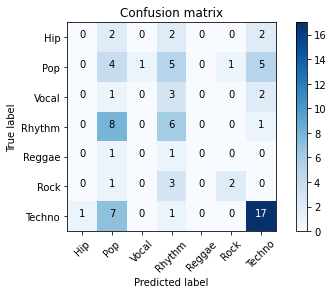

In [19]:
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)


### Gradient Boosting 

Test Set Accuracy =  0.44
Test Set F-score =  0.34
Confusion matrix, without normalization
[[ 1  2  0  3  0  0  0]
 [ 0  5  1  4  0  1  5]
 [ 0  0  2  1  1  0  2]
 [ 1  5  0  6  0  0  3]
 [ 0  1  0  1  0  0  0]
 [ 0  1  0  3  0  2  0]
 [ 1  4  0  3  0  0 18]]


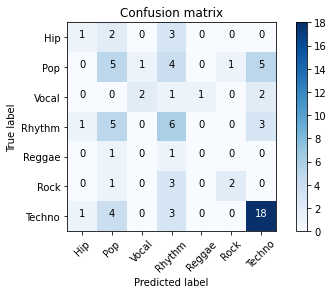

In [20]:
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)



### Support Vector Machines

Test Set Accuracy =  0.35
Test Set F-score =  0.20
Confusion matrix, without normalization
[[ 0  4  0  1  0  0  1]
 [ 0  4  0  5  0  0  7]
 [ 0  4  0  0  0  0  2]
 [ 0  8  0  6  0  0  1]
 [ 0  1  0  1  0  0  0]
 [ 0  2  0  2  0  1  1]
 [ 0  8  0  2  0  0 16]]


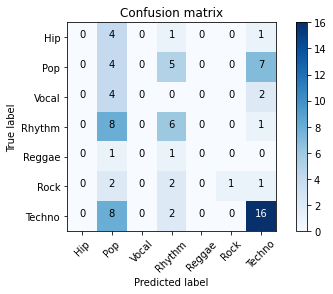

In [21]:
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='linear')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)